In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

### Upload the Data

In [2]:
image_size = (48, 48)
batch = 32

train = keras.preprocessing.image_dataset_from_directory(
    './input/Chess',
    validation_split=.2,
    subset='training',
    seed=42,
    image_size=image_size,
    batch_size=batch,
    label_mode='categorical'
)

Found 552 files belonging to 6 classes.
Using 442 files for training.


In [3]:
validation = keras.preprocessing.image_dataset_from_directory(
    './input/Chess/',
    validation_split=.2,
    subset='validation',
    seed=42,
    image_size=image_size,
    batch_size=batch,
    label_mode='categorical'
)

Found 552 files belonging to 6 classes.
Using 110 files for validation.


#### Exploring the data

In [4]:
def display_samples(dataset, n_samples, classes_name):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(n_samples):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(classes_name[np.argmax(labels[i])])
            plt.axis("off")

(48, 48, 3)


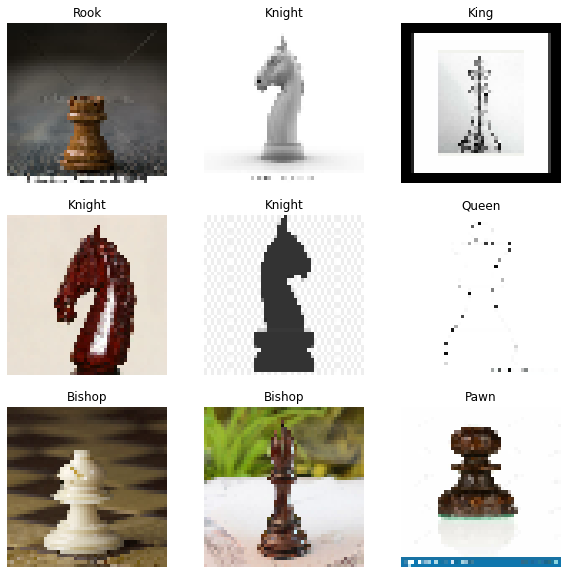

In [5]:
display_samples(train, 9, train.class_names)
for images, labels in train.take(1):
        for i in range(1):
            print(images[i].shape)
            

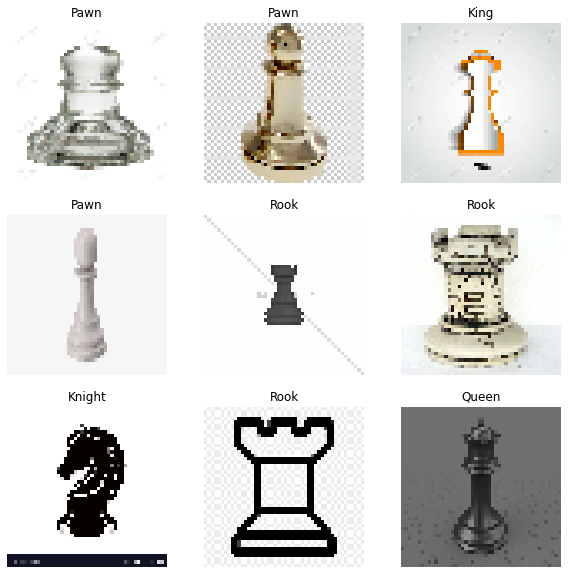

In [6]:
display_samples(validation, 9, validation.class_names)

In [7]:
class_names = train.class_names
labels = np.array([])
for _, label in train:
    labels = np.concatenate((labels, np.argmax(label, axis=-1)))
_, counts = np.unique(labels, return_counts=True)

In [8]:
total = counts.sum()
print("The ratio of each piece")
for i in range(len(counts)):
    print(f'{class_names[i]}: {counts[i]} (%{round(counts[i] / total * 100)})')

The ratio of each piece
Bishop: 71 (%16)
King: 62 (%14)
Knight: 85 (%19)
Pawn: 83 (%19)
Queen: 64 (%14)
Rook: 77 (%17)


## Machine Learning Model

In [9]:
input_shape = (image_size[0], image_size[1], 3)
reg = keras.regularizers.l2(0.0005)

model = keras.Sequential()
model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=image_size + (3,), kernel_regularizer=reg))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding="same", activation="relu", kernel_regularizer=reg))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding="same", activation="relu", kernel_regularizer=reg))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(train.class_names), activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

### Train Data

In [10]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)
#You can increase the number of epochs to get a more accurate result with the data and reduce the loss
epochs = 40
model.fit(
    train,
    epochs=epochs,
    validation_data=validation
);

Epoch 1/40
14/14 [==============================] - 14s 414ms/step - loss: 2.4008 - accuracy: 0.2104 - val_loss: 9.6324 - val_accuracy: 0.2364
Epoch 2/40
14/14 [==============================] - 5s 218ms/step - loss: 2.1522 - accuracy: 0.2353 - val_loss: 4.8912 - val_accuracy: 0.1182
Epoch 3/40
14/14 [==============================] - 5s 214ms/step - loss: 2.1927 - accuracy: 0.1833 - val_loss: 2.6625 - val_accuracy: 0.2182
Epoch 4/40
14/14 [==============================] - 5s 217ms/step - loss: 2.0274 - accuracy: 0.2489 - val_loss: 2.4670 - val_accuracy: 0.1545
Epoch 5/40
14/14 [==============================] - 5s 216ms/step - loss: 1.9884 - accuracy: 0.2715 - val_loss: 2.3299 - val_accuracy: 0.2000
Epoch 6/40
14/14 [==============================] - 5s 214ms/step - loss: 1.9040 - accuracy: 0.2964 - val_loss: 1.9973 - val_accuracy: 0.2818
Epoch 7/40
14/14 [==============================] - 5s 215ms/step - loss: 1.8603 - accuracy: 0.2964 - val_loss: 1.9504 - val_accuracy: 0.2455
Epoch

## Let's Evaluate the Model

Let's Graph Training and Validation Data

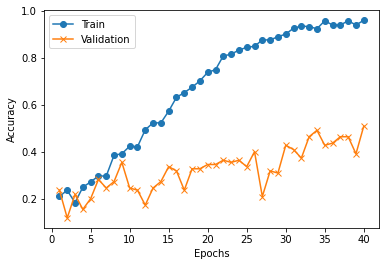

In [11]:
epochs_range = [i+1 for i in range(epochs)]
plt.plot(epochs_range, model.history.history['accuracy'], '-o', label='Train')
plt.plot(epochs_range, model.history.history['val_accuracy'], '-x',label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend();

### Confusion Matrix

In [12]:
y_pred = np.argmax(model.predict(validation), axis=-1)

predictions = np.array([])
labels =  np.array([])
for x, y in validation:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

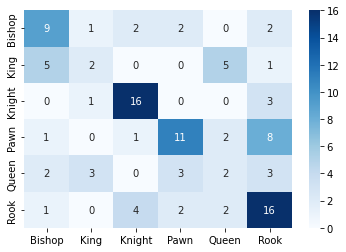

In [13]:
conf = tf.math.confusion_matrix(labels=labels, predictions=predictions)
sns.heatmap(conf, annot=True, cmap='Blues', yticklabels=class_names, xticklabels=class_names);